## Overview
In this notebook, we will implement a simple perceptron with 2 inputs and train it on an 8x8 card. 
*  The perceptron will try and predict a horizontal boundary for a single card. 
*  We will then try to <mark>plot a map of weights and biases and see how errors of the perceptron changes in that space</mark>
*  We will then try to create poor training data, and plot the "error space"
  
## Perceptron solution space
We actually have 4 dimensions: 
 * 2 weights for the perceptron,
 * perceptron bias,
 * The error rate = which is the number of prediction errors normaized to 1 (i.e. `wrong_predictions/total_predictions`)

#### 3d plot
 * This can be plotted as 3d plot of weights and the error rate
 * The space looks smooth, with no discontinuities an no visible local minima. 

<img src ="../static/3dplot.png" title ="Weights and error 3d plot" width = "400px">

#### 4d plot
 * Or as a 4d plot of weights, the error rate. The 4th dimension is the color scale. 
 * Color corresponds to the value  of `bias` that returned the least prediction errors.
 * The best weights and biases for the perceptron can be seen in the chart
 

<img src ="../static/4dplot.png" title ="Weights and error and bias 4d plot" width = "600px">

## The Data
* Each card is generated as a 8x8 matrix. 
* At some random horizontal offset (in the card below its `y>5`), the card will only output positive values.
* Positive output is shows in green, negative in red.
* The card, in essence, is horizontally partitioned between positive and negative regions.
* The perceptron should be able to learn this boundary.

<img src="../static/h1.png" alt="Card" style="width: 200px;">

### Input Vector
For training purposes, the inputs are stored as a one dimensional array X, of 64 elements. 
* Inputs are the `(x,y)` co-ordinates of the card. Hence, in a range of `(0,0)` to `(7,7)`.
* Green corresponds to inputs that must produce a positive output, red to negative. 

E.g. here the inputs will be represented as

``` python
    X =  [[0,0],[0,1],[0, 2] .. [0, 7],[1, 0],[1, 1] .. [7, 7,]]
```

### Output Vector
The outputs are correspondingly stored in a one dimensional array Y, of 64 elements.
* Every value is `1` or `-1`
* Every 8 elements represent a vertical column in the card,

![Serialized Output](../static/serialized-y.png)

``` python
   

#(x,y): (0,0)   (0,1)   (0,2)   (0,3)   (0,4)   (0,5)   (0,6)   (0,7)        
    Y = [
        -1,     -1,     -1,     -1,     -1,     -1,     1,      1, 
        
       ...
       
        -1,     -1,     -1,     -1,     -1,     -1,     1,      1,         
    ]
#(x,y): (7,0)   (7,1)   (7,2)   (7,3)   (7,4)   (7,5)   (7,6)   (7,7)    
```


In [ ]:
import numpy as np
import copy
from matplotlib import pyplot as plt
import random
%matplotlib inline

In [ ]:

#generate a training card with a rectangular section marked positive 
def training_card(size=8, horizontal_partition = True, vertical_partition = True):
    X = np.zeros((size*size,2))
    Y = np.zeros([X.shape[0]])
    
    s = 0
    t_y = random.uniform(size/4,3*size/4) if horizontal_partition else -1
    t_x = random.uniform(0,size) if vertical_partition else -1  
    print("card_t:",t_x,t_y)
    for i in range (0,size):    
        for j in range (0,size):
            X[s]=[i,j] 
            Y[s]= 1 if (j> t_y and i>t_x) else -1
            s+=1
    return (X,Y)            

def draw_card(X,Y):
    plt.figure(figsize=(2,2))
    for i, x in enumerate(X):
        if Y[i] > 0:
            plt.scatter(x[0], x[1], s=100, marker='s', color='green',linewidths=2)
        # Plot the positive samples
        else:
            plt.scatter(x[0], x[1], s=100, marker='s', color='red', linewidths=2)
        

#### Perceptron Algorithm

$$ 
    z = \sum_{i=1}^n x_i w_i + b 
$$

$$ 
    output = \begin{cases}
        1 & \text{if }\ z > T \text{\, where T is some threshold }
        \\-1 & \text{otherwise}
        \end{cases}
$$
#### Learning 
We adjust the weight to reduce the error
$$
    \text{if } y*a \leq 0 \text{ then }
    \bigg|\begin{multline}
    \begin{aligned}
    w_i &= w_i + y x_i \text{ for i  = 1,2,3,..,n} \\
    b &= b + y
    \end{aligned}
    \end{multline}
$$



In [ ]:
import sys, site
sys.path.insert(0,"..") 
from perceptron import perceptron as tron
import importlib
importlib.reload(tron)

#generate a random card and train to detect horizontal partitions 
weights = np.zeros(2)
bias = 0
(X,Y) = training_card(vertical_partition=False)
draw_card(X,Y)
plt.show()
(weights,bias, convergence) = tron.perceptron(X,Y,weights, bias,epochs=50)

def debug_training_weights(weights, bias, convergence):
    ##
    # Try changing the number of epochs. Lower epochs are usually better. 
    ##
    if convergence:
        print(f"CONVERGENCE! Perceptron converged in  (epoch:{convergence})")
    else: 
        print(f"Perceptron failed to converge")
    print(f"Weights => {weights}, bias={bias}\n{'-'*40}\n")

debug_training_weights(weights, bias, convergence)


#print out any prediction errors the perceptron has
def debug_function(x,y,a):
    if (a * y) <= 0 :
        print(f"x={x}, y={y}, a={a}", "\x1b[31mMismatch\x1b[0m" )


## Solution Space
We now know what the weights for training were. You can see that prited above.
But what does the solution space look like? Does it have many hills, is it smooth?

We will plot that below as a few surfaces. We actually have 4 dimensions: 2 weights, one bias, and an error rate that we will calculate.


In [109]:
num_samples = 40
weight1 = np.linspace(-20, 20, num=num_samples)
weight2 = np.linspace(-20, 20, num=num_samples)
biases_range =  np.linspace(-40, 40, num=num_samples)
errors = np.zeros((num_samples,num_samples))
biases = np.zeros((num_samples,num_samples))


## vary the weights and see how many errors the perceptron makes
for w2 in range(0,num_samples): #y-axis (y=0 = first row of matrix)
    for w1 in range(0,num_samples): #x-axis (x=0 first column of matrix)
        w = [weight1[w1],weight2[w2]]
        min_error = 64
        min_bias = 0
        for b_i in range(0,num_samples): #biases are rendered as the color axis             
            b = biases_range[b_i]
            error_count = tron.predict_only(X, Y, w, b, debug_function=None, summarize=False)
            if error_count <= min_error:
                min_error = error_count 
                min_bias = b
        errors[w2][w1] =  min_error/64
        biases[w2][w1] = min_bias
        #print(f"w:{weights[w]},b:{biases[b]},cost:{z[w][b]}")


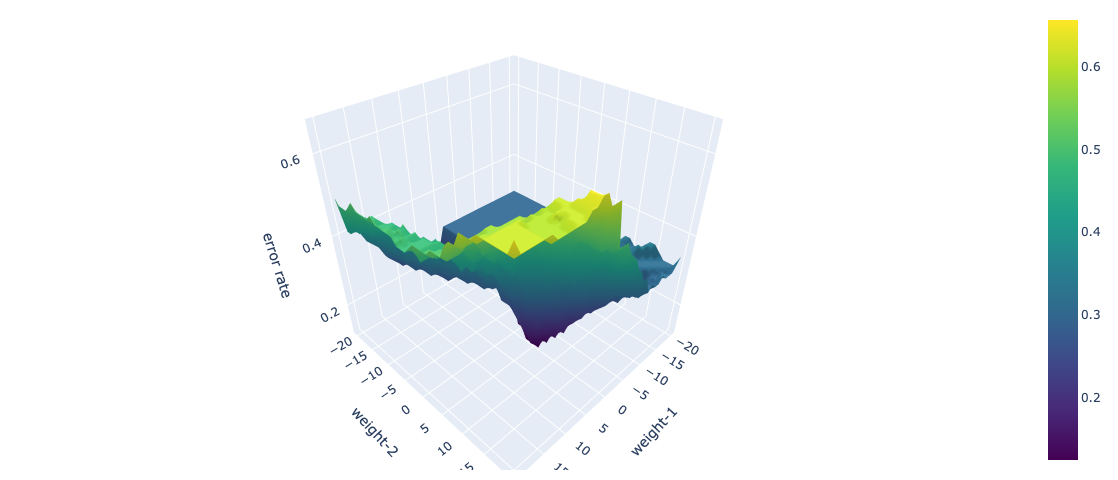

In [110]:
import plotly.graph_objects as go
f1 = go.Figure(data=[go.Surface( x=weight1, y=weight2, z=errors, colorscale='Viridis')])
f1.update_layout(scene = dict(
                    xaxis_title='weight-1',
                    yaxis_title='weight-2',
                    zaxis_title='error rate'),
                    width=800,
                    height=480,
                    margin=dict(r=20, b=10, l=10, t=10))
f1.show()

Scale = Jet


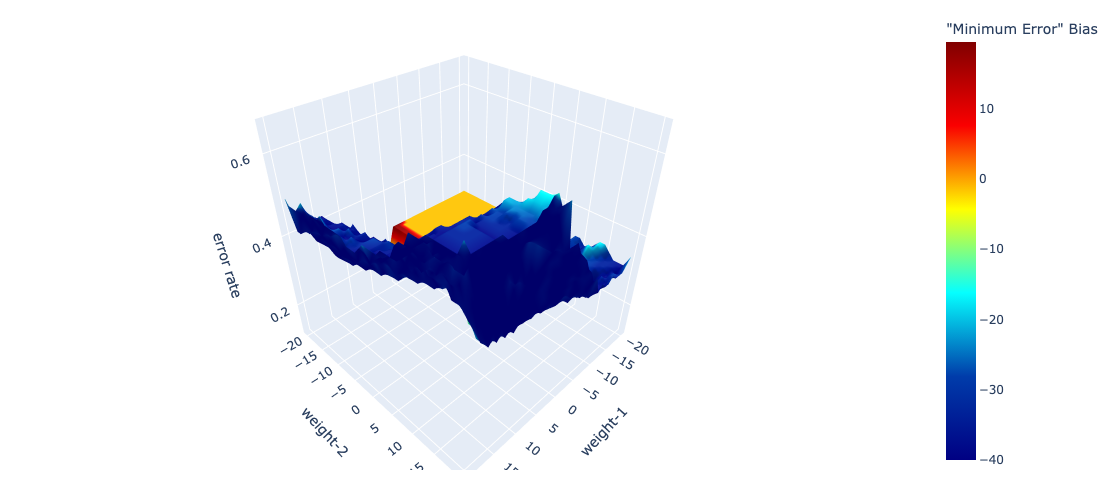

In [111]:
import plotly.graph_objects as go
#scales = ['Blackbody','Bluered','Blues','Earth','Electric','Greens','Greys','Hot','Jet','Picnic','Portland','Rainbow','RdBu','Reds','Viridis','YlGnBu','YlOrRd']
scales=['Jet']
for scale in scales:
    print(f"Scale = {scale}")
    f2 = go.Figure(data=[go.Surface( 
        x=weight1, 
        y=weight2, 
        z=errors, 
        surfacecolor = biases, 
        colorscale=scale,
        colorbar={"title": '"Minimum Error" Bias'}
    )])
    f2.update_layout(scene = dict(
                        xaxis_title='weight-1',
                        yaxis_title='weight-2',
                        zaxis_title='error rate'
                        ),
                        width=800,
                        height=480,                      
                        margin=dict(r=20, b=10, l=10, t=10))
    f2.show()

## Noise in training data
 * Generate a card with lots of noise in the data. 
 * Is this data neatly linearly separable.
 * How does the solution space look now?
 * Will it converge?

card_t: -1 2.19823124587937


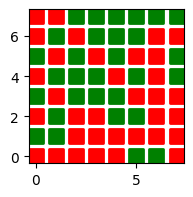

Perceptron failed to converge
Weights => [-3. 10.], bias=-14.0
----------------------------------------

x=[0. 1.], y=1.0, a=-4.0 Mismatch
x=[0. 2.], y=-1.0, a=6.0 Mismatch
x=[0. 4.], y=-1.0, a=26.0 Mismatch
x=[0. 6.], y=-1.0, a=46.0 Mismatch
x=[0. 7.], y=-1.0, a=56.0 Mismatch
x=[1. 1.], y=1.0, a=-7.0 Mismatch
x=[1. 3.], y=-1.0, a=13.0 Mismatch
x=[1. 5.], y=-1.0, a=33.0 Mismatch
x=[1. 7.], y=-1.0, a=53.0 Mismatch
x=[2. 2.], y=-1.0, a=0.0 Mismatch
x=[2. 6.], y=-1.0, a=40.0 Mismatch
x=[3. 5.], y=-1.0, a=27.0 Mismatch
x=[4. 2.], y=1.0, a=-6.0 Mismatch
x=[4. 4.], y=-1.0, a=14.0 Mismatch
x=[5. 0.], y=1.0, a=-29.0 Mismatch
x=[5. 2.], y=1.0, a=-9.0 Mismatch
x=[5. 3.], y=-1.0, a=1.0 Mismatch
x=[5. 5.], y=-1.0, a=21.0 Mismatch
x=[6. 0.], y=1.0, a=-32.0 Mismatch
x=[6. 4.], y=-1.0, a=8.0 Mismatch
x=[6. 5.], y=-1.0, a=18.0 Mismatch
x=[6. 6.], y=-1.0, a=28.0 Mismatch
x=[7. 6.], y=-1.0, a=25.0 Mismatch
Prediction Errors:23
-------------------------
Error rate was 35.9375%
-------------------------


In [127]:
#generate a regular card
(X,Y) = training_card(vertical_partition=False)

##
# Make the data noisy by reversing about 50% of the training set. 
for i,y in enumerate(Y):
        Y[i] = -Y[i] if not round(random.uniform(0,1)) else Y[i]
draw_card(X,Y)
plt.show()

##
# give it a good 50 epochs. 
# data is not likely to be linearly seprable, so there should be some amount of error
##
(weights,bias, convergence) = tron.perceptron(X,Y,np.zeros(2), 0,epochs=50)
debug_training_weights(weights, bias, convergence)

#Predict and print info about mismatches. 
num_errors = tron.predict_only(X,Y,weights, bias,debug_function)
print(f"{'-'*25}\nError rate was {num_errors/64*100}%\n{'-'*25}")


In [129]:
##
# Traverse the entire space of weights and biases and see how it affects the error rate
##
num_samples = 40
weight1 = np.linspace(-20, 20, num=num_samples)
weight2 = np.linspace(-20, 20, num=num_samples)
biases_range =  np.linspace(-40, 40, num=num_samples)
errors = np.zeros((num_samples,num_samples))
biases = np.zeros((num_samples,num_samples))


## vary the weights and see how many errors the perceptron makes
for w2 in range(0,num_samples): #y-axis (y=0 = first row of matrix)
    for w1 in range(0,num_samples): #x-axis (x=0 first column of matrix)
        w = [weight1[w1],weight2[w2]]
        min_error = 64
        min_bias = 0
        for b_i in range(0,num_samples): #biases are rendered as the color axis             
            b = biases_range[b_i]
            error_count = tron.predict_only(X, Y, w, b, debug_function=None, summarize=False)
            if error_count <= min_error:
                min_error = error_count 
                min_bias = b
        errors[w2][w1] =  min_error/64
        biases[w2][w1] = min_bias
        #print(f"w:{weights[w]},b:{biases[b]},cost:{z[w][b]}")


import plotly.graph_objects as go
f3 = go.Figure(data=[go.Surface( 
    x=weight1, 
    y=weight2, 
    z=errors, 
    surfacecolor = biases, 
    colorscale='BlueRed',
    colorbar={"title": '"Minimum Error" Bias'}
)])
f3.update_layout(scene = dict(
                    xaxis_title='weight-1',
                    yaxis_title='weight-2',
                    zaxis_title='error rate'
                    ),
                    width=800,
                    height=480,                      
                    margin=dict(r=20, b=10, l=10, t=10))
f3.show()